<a href="https://colab.research.google.com/github/sejin-sim/Competitions/blob/main/%5BKAGGLE%5D_San_Francisco_Crime_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### San Francisco Crime Classification

> evaluation :  multi-class logarithmic loss

Dates - timestamp of the crime incident

Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.

Descript - detailed description of the crime incident (only in train.csv)

DayOfWeek - the day of the week

PdDistrict - name of the Police Department District

Resolution - how the crime incident was resolved (only in train.csv)

Address - the approximate street address of the crime incident 

X - Longitude

Y - Latitude

In [1]:
!pip install bayesian-optimization

# ! git clone --recursive https://github.com/Microsoft/LightGBM
# ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [2]:
! cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
! kaggle competitions download -c sf-crime

 48% 9.00M/18.7M [00:00<00:00, 24.6MB/s]
100% 18.7M/18.7M [00:00<00:00, 42.3MB/s]
 23% 5.00M/22.1M [00:00<00:00, 19.1MB/s]
100% 22.1M/22.1M [00:00<00:00, 63.5MB/s]
  0% 0.00/2.35M [00:00<?, ?B/s]
100% 2.35M/2.35M [00:00<00:00, 77.7MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
train = pd.read_csv('/content/train.csv.zip')
test = pd.read_csv('/content/test.csv.zip', index_col='Id')
submission = pd.read_csv('/content/sampleSubmission.csv.zip',index_col='Id')

In [5]:
Tename = list(test)
Tename

['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y']

In [6]:
df_train = train[Tename]
df_train

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [7]:
df = pd.concat((df_train,test))

In [8]:
df.isnull().sum()

Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

In [9]:
target = train['Category']
target.value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [10]:
from sklearn.preprocessing import LabelEncoder

LB = LabelEncoder() 
target = LB.fit_transform(target)
print(LB.classes_)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']


In [11]:
date = pd.to_datetime(df['Dates'])
df['Date'] = date.dt.date
df['Year'] = date.dt.year
df['Month'] = date.dt.month
df['Day'] = date.dt.day
df['Hour'] = date.dt.hour

In [12]:
df.drop('Dates', axis=1, inplace=True)

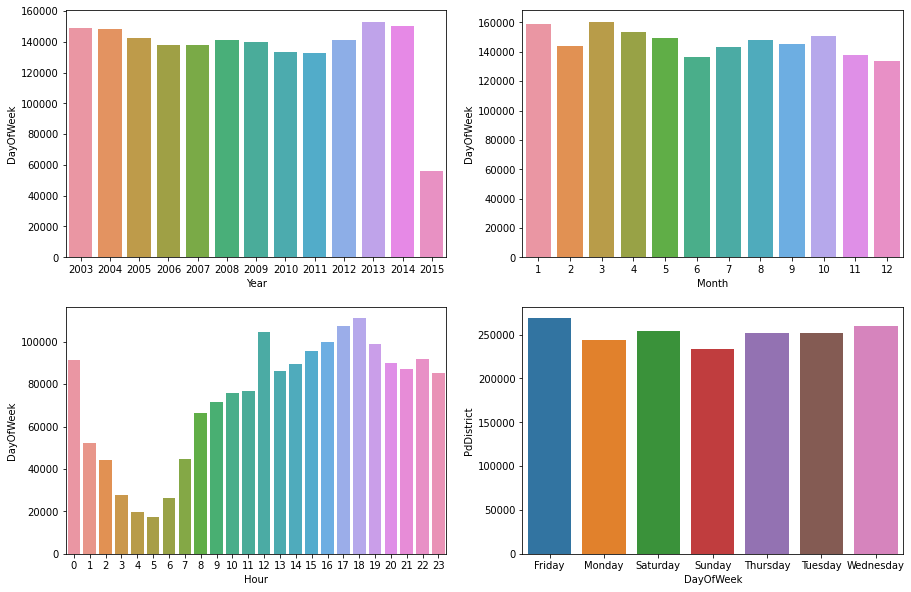

In [13]:
year = df.groupby('Year').count().iloc[:,0]
month = df.groupby('Month').count().iloc[:,0]
hour = df.groupby('Hour').count().iloc[:,0]
dayofweek = df.groupby('DayOfWeek').count().iloc[:, 0]

figure, axs = plt.subplots(2,2, figsize = (15,10))

sns.barplot(x=year.index, y= year,ax = axs[0][0])
sns.barplot(x=month.index, y= month,ax = axs[0][1])
sns.barplot(x=hour.index, y= hour,ax = axs[1][0])
sns.barplot(x=dayofweek.index, y= dayofweek,ax = axs[1][1])

In [14]:
lb = LabelEncoder()
df['PdDistrict'] = lb.fit_transform(df["PdDistrict"])
df['DayOfWeek'] = lb.fit_transform(df["DayOfWeek"])
df

,DayOfWeek,PdDistrict,Address,X,Y,Date,Year,Month,Day,Hour
0,6,4,OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,2015,5,13,23
1,6,4,OAK ST / LAGUNA ST,-122.425892,37.774599,2015-05-13,2015,5,13,23
2,6,4,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015-05-13,2015,5,13,23
3,6,4,1500 Block of LOMBARD ST,-122.426995,37.800873,2015-05-13,2015,5,13,23
4,6,5,100 Block of BRODERICK ST,-122.438738,37.771541,2015-05-13,2015,5,13,23
...,...,...,...,...,...,...,...,...,...,...
884257,6,3,2600 Block of BRYANT ST,-122.408983,37.751987,2003-01-01,2003,1,1,0
884258,6,4,1900 Block of WASHINGTON ST,-122.425342,37.792681,2003-01-01,2003,1,1,0
884259,6,2,5500 Block of MISSION ST,-122.445418,37.712075,2003-01-01,2003,1,1,0
884260,6,0,1500 Block of HUDSON AV,-122.387394,37.739479,2003-01-01,2003,1,1,0


In [15]:
df['Block'] = df['Address'].str.contains('Block')
df['ST'] = df['Address'].str.contains('ST')

In [16]:
df['Block'] = lb.fit_transform(df["Block"])
df['ST'] = lb.fit_transform(df["ST"])

In [17]:
df.drop("Address", axis =1, inplace = True)

In [18]:
print(df["X"].min(), df["X"].max())
print(df["Y"].min(), df["Y"].max())

print(len(df.loc[df["X"] >= -120.5]))
print(len(df.loc[df["Y"] >= 90]))

X_median = df[df["X"] < -120.5]["X"].median()
Y_median = df[df["Y"] < 90]["Y"].median()
df.loc[df["X"] >= -120.5, "X"] = X_median
df.loc[df["Y"] >= 90, "Y"] = Y_median

df["X+Y"] = df["X"] + df["Y"]
df["X-Y"] = df["X"] - df["Y"]
df.isnull().sum()

-122.51364206429 -120.5
37.7078790224135 90.0
143
143


DayOfWeek     0
PdDistrict    0
X             0
Y             0
Date          0
Year          0
Month         0
Day           0
Hour          0
Block         0
ST            0
X+Y           0
X-Y           0
dtype: int64

In [19]:
df.drop("Date", axis = 1, inplace = True)
df

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Block,ST,X+Y,X-Y
0,6,4,-122.425892,37.774599,2015,5,13,23,0,1,-84.651293,-160.200490
1,6,4,-122.425892,37.774599,2015,5,13,23,0,1,-84.651293,-160.200490
2,6,4,-122.424363,37.800414,2015,5,13,23,0,1,-84.623949,-160.224777
3,6,4,-122.426995,37.800873,2015,5,13,23,1,1,-84.626123,-160.227868
4,6,5,-122.438738,37.771541,2015,5,13,23,1,1,-84.667196,-160.210279
...,...,...,...,...,...,...,...,...,...,...,...,...
884257,6,3,-122.408983,37.751987,2003,1,1,0,1,1,-84.656996,-160.160970
884258,6,4,-122.425342,37.792681,2003,1,1,0,1,1,-84.632661,-160.218024
884259,6,2,-122.445418,37.712075,2003,1,1,0,1,1,-84.733343,-160.157493
884260,6,0,-122.387394,37.739479,2003,1,1,0,1,0,-84.647915,-160.126873


In [20]:
new_train = df[:train.shape[0]]
new_test = df[train.shape[0]:]
del train, test

In [21]:
new_test

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour,Block,ST,X+Y,X-Y
0,3,0,-122.399588,37.735051,2015,5,10,23,1,0,-84.664537,-160.134639
1,3,0,-122.391523,37.732432,2015,5,10,23,0,1,-84.659091,-160.123955
2,3,4,-122.426002,37.792212,2015,5,10,23,1,1,-84.633790,-160.218214
3,3,2,-122.437394,37.721412,2015,5,10,23,1,1,-84.715982,-160.158806
4,3,2,-122.437394,37.721412,2015,5,10,23,1,1,-84.715982,-160.158806
...,...,...,...,...,...,...,...,...,...,...,...,...
884257,6,3,-122.408983,37.751987,2003,1,1,0,1,1,-84.656996,-160.160970
884258,6,4,-122.425342,37.792681,2003,1,1,0,1,1,-84.632661,-160.218024
884259,6,2,-122.445418,37.712075,2003,1,1,0,1,1,-84.733343,-160.157493
884260,6,0,-122.387394,37.739479,2003,1,1,0,1,0,-84.647915,-160.126873


In [27]:
!nvidia-smi

Fri Mar  5 03:11:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |    361MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
        
X = new_train
y = target


def XGB_cv(max_depth, gamma, colsample_bytree, min_child_weight):
    
    model = xgb.XGBClassifier(
                              use_label_encoder=False,
                              tree_method = 'gpu_hist',
                              predictor = 'gpu_predictor',
                              objective ='multi:softmax',     
                              eval_metric = 'mlogloss',
        
                              max_depth = int(max_depth),   
                              gamma=gamma,
                              colsample_bytree=colsample_bytree,
                              min_child_weight = int(min_child_weight))
    
    cval = cross_val_score(model, X, y, scoring='neg_log_loss', cv=5).mean()
    return cval

# 주어진 범위 사이에서 적절한 값을 찾는다.
pbounds={
    'max_depth': (5,12),
    'gamma': (0, 1),
    'colsample_bytree': (0.5, 1.0),
    'min_child_weight' : (1, 3)
}
xgboostBO = BayesianOptimization(f = XGB_cv,pbounds = pbounds, verbose = 2, random_state = 1 )

# 메소드를 이용해 최대화!
xgboostBO.maximize(init_points=3, n_iter = 10)

print(xgboostBO.max) # 찾은 파라미터 값 확인

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... |
-------------------------------------------------------------------------
|  1        | -4.291    |  0.7085   |  0.7203   |  5.001    |  1.605    |
|  2        | -4.216    |  0.5734   |  0.09234  |  6.304    |  1.691    |
|  3        | -4.694    |  0.6984   |  0.5388   |  7.934    |  2.37     |
|  4        | -4.531    |  0.5      |  0.0      |  12.0     |  1.0      |
|  5        | -4.054    |  0.5      |  0.0      |  5.0      |  3.0      |
|  6        | -5.976    |  1.0      |  0.0      |  12.0     |  3.0      |
|  7        | -4.465    |  0.5      |  1.0      |  9.66     |  1.0      |
|  8        | -4.532    |  1.0      |  1.0      |  5.576    |  3.0      |
|  9        | -5.39     |  1.0      |  0.0      |  8.128    |  1.0      |
|  10       | -5.998    |  1.0      |  1.0      |  12.0     |  1.0      |
|  11       | -4.215    |  0.5      |  0.0      |  6.534    |  3.0      |
|  12       | -4.473    |  0.5      | 

In [29]:
fit_xgb = xgb.XGBClassifier(                           
                            max_depth= int( xgboostBO.max['params']['max_depth'] ),
                            gamma= xgboostBO.max['params']['gamma'],
                            colsample_bytree=xgboostBO.max['params']['colsample_bytree'],
                            min_child_weight = xgboostBO.max['params']['min_child_weight'],
                            
                             use_label_encoder=False,
                             tree_method = 'gpu_hist',
                             predictor = 'gpu_predictor',
                             objective ='multi:softprob',     
                             eval_metric = 'mlogloss')

model  = fit_xgb.fit(X, y)
pred_xgb = model.predict_proba(new_test)

In [30]:
pred_xgb

array([[0.00357052, 0.12062664, 0.00025482, ..., 0.11717621, 0.03183086,
        0.01902804],
       [0.00232678, 0.07395695, 0.00020695, ..., 0.06968171, 0.07074444,
        0.03154156],
       [0.00285423, 0.06609729, 0.00062101, ..., 0.0895575 , 0.02017285,
        0.0041624 ],
       ...,
       [0.00136594, 0.08111845, 0.00269173, ..., 0.0862441 , 0.02483881,
        0.00793695],
       [0.00905164, 0.10124277, 0.00367126, ..., 0.06447678, 0.03281356,
        0.01317477],
       [0.00208988, 0.05731203, 0.0021929 , ..., 0.0781529 , 0.01190484,
        0.00614051]], dtype=float32)

In [31]:
submission1 = pd.DataFrame(pred_xgb,columns=LB.inverse_transform(np.linspace(0, 38, 39, dtype='int16')),index=new_test.index)
submission1.to_csv('/content/drive/MyDrive/kaggle/XGB_3.csv', index_label='Id')

In [32]:
submission1

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.003571,0.120627,0.000255,0.001301,0.036965,0.001822,0.004484,0.018506,0.003339,0.000885,0.000351,0.000992,0.002013,0.006940,0.000346,0.005332,0.176406,0.001393,0.000350,0.082868,0.078396,0.101585,0.000177,0.000514,0.000887,0.031595,0.004356,0.017740,0.004715,0.000344,0.005712,0.000609,0.043631,0.000163,0.004200,0.068596,0.117176,0.031831,0.019028
1,0.002327,0.073957,0.000207,0.000875,0.002918,0.002094,0.010085,0.044201,0.004136,0.000364,0.000253,0.000319,0.001498,0.004280,0.001292,0.002222,0.064310,0.002171,0.000558,0.004243,0.047552,0.419519,0.000164,0.000848,0.000687,0.052254,0.000587,0.009707,0.002808,0.000289,0.005017,0.000318,0.032053,0.000156,0.001084,0.032682,0.069682,0.070744,0.031542
2,0.002854,0.066097,0.000621,0.000256,0.113680,0.001561,0.001802,0.012206,0.004752,0.000602,0.000332,0.000332,0.003825,0.011724,0.000185,0.003609,0.350499,0.000989,0.000292,0.015928,0.094242,0.054586,0.000147,0.001185,0.000492,0.016916,0.000417,0.011836,0.005633,0.000188,0.008108,0.000444,0.025714,0.000137,0.007337,0.066579,0.089557,0.020173,0.004162
3,0.002368,0.150544,0.000275,0.001093,0.031145,0.002290,0.004130,0.018135,0.005386,0.000534,0.000455,0.001132,0.003310,0.008341,0.000399,0.005660,0.120141,0.002365,0.000313,0.043348,0.080332,0.112559,0.000176,0.000508,0.000895,0.039031,0.002542,0.021969,0.005884,0.000463,0.007287,0.000594,0.033039,0.000162,0.004165,0.074944,0.168232,0.028353,0.017503
4,0.002368,0.150544,0.000275,0.001093,0.031145,0.002290,0.004130,0.018135,0.005386,0.000534,0.000455,0.001132,0.003310,0.008341,0.000399,0.005660,0.120141,0.002365,0.000313,0.043348,0.080332,0.112559,0.000176,0.000508,0.000895,0.039031,0.002542,0.021969,0.005884,0.000463,0.007287,0.000594,0.033039,0.000162,0.004165,0.074944,0.168232,0.028353,0.017503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.001506,0.109844,0.002603,0.000893,0.025376,0.003057,0.001828,0.029640,0.006899,0.017922,0.000995,0.001249,0.091869,0.057523,0.000357,0.002228,0.072031,0.005092,0.000552,0.017203,0.075245,0.159454,0.000150,0.002288,0.000691,0.011395,0.001396,0.012819,0.071540,0.005694,0.004015,0.000577,0.053020,0.000138,0.007364,0.036672,0.066231,0.033559,0.009087
884258,0.001234,0.060067,0.005566,0.000219,0.091382,0.009177,0.001191,0.014846,0.003756,0.023886,0.001403,0.000554,0.132064,0.061717,0.000317,0.001611,0.124748,0.001356,0.000864,0.009677,0.070556,0.126366,0.000150,0.009038,0.000711,0.007910,0.000447,0.007303,0.019840,0.000512,0.008531,0.000609,0.063970,0.000138,0.010308,0.041391,0.061692,0.020495,0.004398
884259,0.001366,0.081118,0.002692,0.000804,0.019721,0.002185,0.001060,0.015460,0.002435,0.011424,0.008695,0.001325,0.153090,0.096938,0.000401,0.002257,0.066390,0.001633,0.000447,0.026017,0.066416,0.125206,0.000140,0.000695,0.001033,0.011004,0.003441,0.012501,0.059332,0.002785,0.004358,0.001006,0.048695,0.000124,0.004683,0.044102,0.086244,0.024839,0.007937
884260,0.009052,0.101243,0.003671,0.000616,0.048918,0.004061,0.000929,0.031017,0.001962,0.007201,0.000939,0.001272,0.126791,0.035658,0.000580,0.001852,0.058556,0.000850,0.000616,0.020302,0.058913,0.205623,0.000175,0.001198,0.000879,0.008835,0.001857,0.014543,0.023453,0.001922,0.003277,0.000882,0.060068,0.000152,0.006702,0.044969,0.064477,0.032814,0.013175


In [33]:
! kaggle competitions submit -c sf-crime -f /content/drive/MyDrive/kaggle/XGB_3.csv -m "Message"

100% 417M/417M [00:17<00:00, 25.4MB/s]
Successfully submitted to San Francisco Crime Classification

- 최종 점수

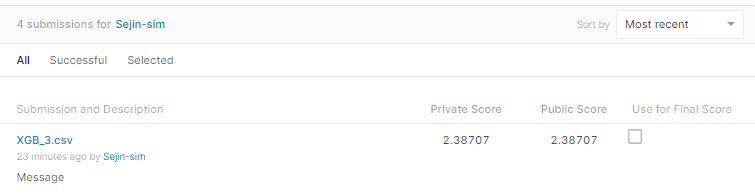